In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns

#setups
%matplotlib inline
sns.set()
#this will let you see all the columns that are in the dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [4]:
columns_to_keep = ['TUCASEID','PEEDUCA','TEAGE','TELFS','TESEX','TESPEMPNOT','TRCHILDNUM','TRDPFTPT','TRERNWA','TUFNWGTP','TUYEAR']
summ_demo_iter = pd.read_csv('../atussum_0321.csv', iterator= True, chunksize=10000, usecols=columns_to_keep)
# summ_demo_iter = pd.read_csv('./atussum_1121-reduced.csv', iterator= True, chunksize=10000, usecols=columns_to_keep)
summ_list = []
for chunk in summ_demo_iter:
    summ_temp = chunk[(chunk.TUYEAR <= 2020)]
    summ_temp = summ_temp.rename(columns={'TUCASEID':'case_id',
                                          'PEEDUCA':'education',
                                          'TEAGE':'age',
                                          'TELFS':'employed',
                                          'TESEX':'gender',
                                          'TESPEMPNOT':'spouse_empl',
                                          'TRCHILDNUM':'num_child',
                                          'TRDPFTPT':'full_part_wrk',
                                          'TRERNWA':'weekly_earn',
                                          'TUFNWGTP':'weights',
                                          'TUYEAR':'year'})
    summ_list.append(summ_temp)
summ_demo_final = pd.concat(summ_list)
summ_demo_final.shape

columns_2 = ['TUCASEID','TULINENO','HUFAMINC','HEFAMINC','HRYEAR4']
cps_iter = pd.read_csv('../atuscps_0320.dat', iterator= True, chunksize=20000, usecols=columns_2)
cps_list = []

#iterator
for chunk in cps_iter:
    cps_temp = chunk[(chunk.TULINENO == 1) & (chunk.HRYEAR4 <= 2020)]
    cps_temp = cps_temp.rename(columns={'TUCASEID':'case_id','HUFAMINC':'faminc_1','HEFAMINC':'faminc_2','HRYEAR4':'year'})
    cps_list.append(cps_temp)

cps_final = pd.concat(cps_list)
cps_final.reset_index(drop=True, inplace=True)
cps_final.shape
summ_num_ind = summ_demo_final['case_id']
cps_num_ind = cps_final['case_id']
merge = pd.merge(summ_num_ind,cps_num_ind, left_on=['case_id'], right_on=['case_id'], how='inner', suffixes=('_sum', '_cps')).reset_index(drop=True).copy(deep=True)
sum_no_inc = summ_demo_final[(summ_demo_final.weekly_earn == -1)]
both = cps_final[(cps_final.faminc_1 == -1) & (cps_final.faminc_2 == -1)]
test_col = []
for i in range(len(cps_final)):
    if cps_final.faminc_1[i] == -1 and cps_final.faminc_2[i] == -1:
        test_col.append(0)
    elif cps_final.faminc_1[i] > -1:
        test_col.append(cps_final.faminc_1[i])
    elif cps_final.faminc_2[i] > -1:
        test_col.append(cps_final.faminc_2[i])
    else:
        test_col.append(0)
ones = [i for i in test_col if i == 0]
cps_final['income'] = test_col
cps_sub = cps_final[cps_final.income != 0]
cps_income = cps_sub[['case_id', 'income']]
summ_num_ind_2 = summ_demo_final['case_id']
cps_num_ind_2 = cps_sub['case_id']
merge_2 = pd.merge(summ_num_ind_2,cps_income, left_on=['case_id'], right_on=['case_id'], how='inner', suffixes=('_sum', '_cps')).reset_index(drop=True).copy(deep=True)
all_demo_income = pd.merge(summ_demo_final,cps_income, left_on=['case_id'], right_on=['case_id'], how='inner', suffixes=('_sum', '_cps')).reset_index(drop=True).copy(deep=True)
all_demo_income.education.replace(to_replace=[31,32,33,34,35,36,37], value=38, inplace=True)
all_demo_income.education.replace(to_replace=[42], value=41, inplace=True)
salary_education_info = all_demo_income

income_dict = {'1': 'Less than $5,000',
 '2': '$5,000 to $7,499',
 '3': '$7,500 to $9,999',
 '4': '$10,000 to $12,499',
 '5': '$12,500 to $14,999',
 '6': '$15,000 to $19,999',
 '7': '$20,000 to $24,999',
 '8': '$25,000 to $29,999',
 '9': '$30,000 to $34,999',
 '10': ' $35,000 to $39,999',
 '11': ' $40,000 to $49,999',
 '12': ' $50,000 to $59,999',
 '13': ' $60,000 to $74,999',
 '14': ' $75,000 to $99,999',
 '15': ' $100,000 to $149,999 (See note)',
 '16': ' $150,000 and over (See note)'}

edu_dict = {'38':'Less than High School', '39':'High School or GED', '40':'Some College', '41': 'Associates Degree', '43':'Bachelors','44':'Masters', '45':'Professional_Deg', '46':'Doctoral'}
# income_dict = {'1':'$0-$9,999', '2':'$10,000 - $19,999', '3':'$20,000 - $29,000', '4':'$30,000 - $39,999', '5':'$40,000 - $49,999', '6':'$50,000 - $59,999', '7':'$60,000 - $74,999', '8':'$75,000 - $99,999', '9': '$100,000 - $149,999', '10':'$150000 and over'}
# eth_dict = {'1' : 'Hispanic', '2': 'White', '3':'Native American', '4':'Black', '5':'Asian', '6':'Other'}
gender_dict = {'1':'Male','2':'Female'}
spouse_dict = {'1':'Employed', '2':'Not employed'}
part_full_dict = {'1':'Full Time', '2':'Part Time'}
cat_list = ["educaton_text","income_text", "gender_text", "spouse_text", "full_part_text"]
var_list = ["education","income", "gender", "spouse_empl", "full_part_wrk"]
dict_list = [edu_dict, income_dict, gender_dict, spouse_dict, part_full_dict]

def mapping_variables(df,cat_list=cat_list, var_list=var_list, dict_list=dict_list):
    for i in range(len(cat_list)):
        new_col = cat_list[i]
        old_col = var_list[i]
        dicton = dict_list[i]
        df_new = pd.DataFrame(df[old_col])
        df_new =df_new.applymap(str)
        df[new_col] = df_new[old_col].replace(dicton)
mapping_variables(salary_education_info)

In [5]:
salary_education_info.head(10)

,case_id,education,age,employed,gender,spouse_empl,num_child,full_part_wrk,weekly_earn,weights,year,income,educaton_text,income_text,gender_text,spouse_text,full_part_text
0,20030100013280,44,60,2,1,2,0,2,66000,8.155463e+06,2003,13,Masters,"$60,000 to $74,999",Male,Not employed,Part Time
1,20030100013352,41,26,2,2,2,0,2,20000,3.830527e+06,2003,14,Associates Degree,"$75,000 to $99,999",Female,Not employed,Part Time
2,20030100013848,39,36,4,2,1,2,-1,-1,6.622023e+06,2003,7,High School or GED,"$20,000 to $24,999",Female,Employed,-1
3,20030100014165,45,51,1,1,2,2,1,-1,3.068387e+06,2003,14,Professional_Deg,"$75,000 to $99,999",Male,Not employed,Full Time
4,20030100014169,43,32,2,2,1,1,1,57600,3.455425e+06,2003,11,Bachelors,"$40,000 to $49,999",Female,Employed,Full Time
5,20030100014209,39,44,1,2,1,1,1,-1,1.637826e+06,2003,5,High School or GED,"$12,500 to $14,999",Female,Employed,Full Time
6,20030100014427,40,21,1,2,-1,1,1,33250,6.574427e+06,2003,14,Some College,"$75,000 to $99,999",Female,-1,Full Time
7,20030100014550,41,33,1,2,1,3,1,63000,1.528296e+06,2003,12,Associates Degree,"$50,000 to $59,999",Female,Employed,Full Time
8,20030100014758,41,39,1,2,2,4,1,45000,4.277053e+06,2003,8,Associates Degree,"$25,000 to $29,999",Female,Not employed,Full Time
9,20030100014928,40,26,1,1,1,1,1,65000,1.961482e+06,2003,9,Some College,"$30,000 to $34,999",Male,Employed,Full Time


# 4D visualization
In this report, we select depth and hue as specific data dimensions in a conventional plot like a scatter plot.

Text(0.5, 0, 'Education')

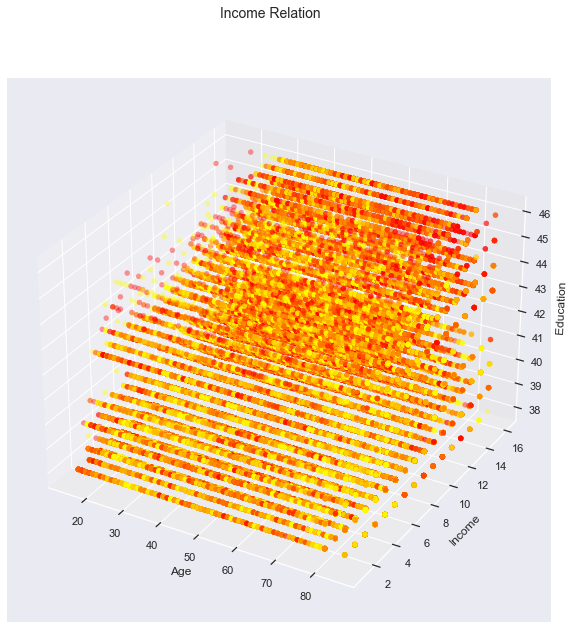

In [7]:
fig = plt.figure(figsize=(10, 10))
t = fig.suptitle('Income Relation', fontsize=14)
ax = fig.add_subplot(111, projection='3d')

xs = list(salary_education_info['age'])
ys = list(salary_education_info['income'])
zs = list(salary_education_info['education'])
data_points =  [(x, y, z) for x, y, z in zip(xs, ys, zs)]
colors = ['red' if wt == 1 else 'yellow' for wt in list(salary_education_info['gender'])]

for data, color in zip(data_points, colors):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.4, c=color, edgecolors='none', s=30)
    
ax.set_xlabel('Age')
ax.set_ylabel('Income')
ax.set_zlabel('Education')